# Question 5: Discovering Frequent Flyer Groups with DBSCAN

## Step A: Data Preparation
We will:
1. Load the `EastWestAirlinesCluster` dataset from the `dmba` library.
2. Inspect structure and basic statistics.
3. Select numeric features suitable for clustering (dropping identifiers and categorical codes).
4. Handle any missing values (the dataset typically has none, but we confirm).
5. Scale features using `StandardScaler` so DBSCAN distance metrics treat them equally.

After this step we'll have a NumPy array / DataFrame of scaled features ready for parameter exploration (eps, min_samples).


In [1]:
# Imports and data loading
import pandas as pd
import numpy as np
from dmba import load_data

# Locate CSV from dmba package and load
df = load_data('EastWestAirlinesCluster.csv')

print(f"Data shape: {df.shape}")
df.head()

Data shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [6]:
# Basic info and statistics
# Check dtypes and missing values
info = df.dtypes.to_frame(name='dtype')
missing = df.isna().sum()
print(info.head())
print("Missing values per column (should be 0):")
print(missing[missing>0])

# Describe numeric columns
numeric_desc = df.describe()
numeric_desc.head()

            dtype
ID#         int64
Balance     int64
Qual_miles  int64
cc1_miles   int64
cc2_miles   int64
Missing values per column (should be 0):
Series([], dtype: int64)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,73601.327582,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,100775.664958,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,18527.500000,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000


In [7]:
# Feature selection for clustering
# Commonly we remove ID variables and qualitative encodings.
# Based on dataset documentation: columns include ID, Award?, etc.

# Identify numeric columns automatically
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop likely identifier columns if present
identifier_like = [c for c in numeric_cols if 'ID' in c.upper() or c.lower() in ['id']]
# Manually inspect potential non-behavioral columns
manual_exclude = []  # Add any columns after inspection if needed

features = [c for c in numeric_cols if c not in set(identifier_like + manual_exclude)]
print(f"Identifier-like columns removed: {identifier_like}")
print(f"Number of numeric feature columns retained: {len(features)}")
features[:10]

Identifier-like columns removed: ['ID#']
Number of numeric feature columns retained: 11


['Balance',
 'Qual_miles',
 'cc1_miles',
 'cc2_miles',
 'cc3_miles',
 'Bonus_miles',
 'Bonus_trans',
 'Flight_miles_12mo',
 'Flight_trans_12',
 'Days_since_enroll']

In [8]:
# Scaling features
from sklearn.preprocessing import StandardScaler

X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled feature array shape:", X_scaled.shape)

# Convert back to DataFrame for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

Scaled feature array shape: (3999, 11)


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
1,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
2,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
3,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
4,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918


## Step B: Finding DBSCAN Parameters (eps, min_samples)
We'll use the k-distance (Nearest Neighbors) plot to choose an epsilon (eps). We set min_samples=5 and look for the elbow in the sorted 5-NN distance curve. Then we fit DBSCAN on the scaled features.

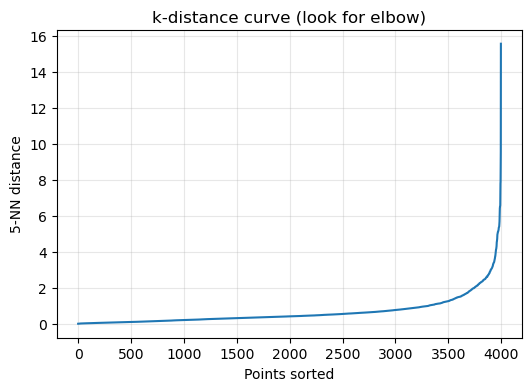

array([0.01678895, 0.01708609, 0.01812006, 0.01889493, 0.01977796,
       0.01999706, 0.02030775, 0.02030775, 0.02085347, 0.02089781])

In [9]:
# k-distance plot for eps selection
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples)
nbrs.fit(X_scaled_df)
# distances matrix shape: (n_samples, k)
distances, indices = nbrs.kneighbors(X_scaled_df)
# Take the distance to the k-th neighbor for each point (last column), then sort
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted")
plt.title("k-distance curve (look for elbow)")
plt.grid(alpha=0.3)
plt.show()

k_distances[:10]

In [11]:
# Heuristic eps detection and DBSCAN fit
from sklearn.cluster import DBSCAN

# Simple knee heuristic: 2nd derivative on the sorted k-distances
# Use robust slicing to avoid very noisy extremes
arr = k_distances
if len(arr) > 20:
    # consider middle 90% to avoid endpoints
    start = int(0.05 * len(arr))
    end = int(0.95 * len(arr))
    work = arr[start:end]
    second_deriv = np.diff(work, n=2)
    knee_idx_local = np.argmax(second_deriv) if len(second_deriv) > 0 else len(work)//2
    eps_guess = work[knee_idx_local]
else:
    # fallback to a high quantile
    eps_guess = float(np.quantile(arr, 0.95))

print(f"Heuristic eps guess: {eps_guess:.4f} (min_samples={min_samples})")

# Fit DBSCAN
clust = DBSCAN(eps=eps_guess, min_samples=min_samples, metric='euclidean')
labels = clust.fit_predict(X_scaled_df)

# Summaries
import pandas as pd
vc = pd.Series(labels).value_counts().sort_index()
num_noise = int(vc.get(-1, 0))
num_clusters = int(vc[vc.index >= 0].shape[0])
print("Label counts (including noise -1):\n", vc)
print(f"Clusters found (excluding noise): {num_clusters}")
print(f"Noise points: {num_noise} ({num_noise/len(labels):.1%})")

Heuristic eps guess: 2.0419 (min_samples=5)
Label counts (including noise -1):
 -1     175
 0    2455
 1    1332
 2      16
 3       9
 4       7
 5       5
Name: count, dtype: int64
Clusters found (excluding noise): 6
Noise points: 175 (4.4%)


## Step C: Analyzing DBSCAN Results
We will report:
1. Number of clusters (excluding noise) and number of noise points.
2. Cluster centroids (means) in original feature scale and standardized scale.
3. A heatmap of standardized centroids to compare relative feature magnitudes.
4. Characteristics of noise points: how they differ from overall distribution (z-score extremes).
5. Optional: Silhouette score computed only on non-noise points to gauge separation.

Label counts (including noise -1):
 -1     175
 0    2455
 1    1332
 2      16
 3       9
 4       7
 5       5
Name: count, dtype: int64
Clusters found (excluding noise): 6
Noise points: 175 (4.4%)

Centroids in original units (first 10 features):


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
cluster,,,,,,,,,,
0,58233.959,61.591,1.698,1.0,1.0,9821.213,8.920,192.557,0.567,3815.952
1,78627.071,102.993,2.642,1.0,1.0,25826.017,14.418,504.249,1.576,4571.059
2,39218.500,0.000,1.000,2.0,1.0,9189.250,13.500,209.375,0.812,3511.188
3,51096.000,0.000,1.000,3.0,1.0,15561.667,14.333,44.444,0.222,3603.444
4,40618.000,0.000,1.000,2.0,1.0,8444.143,14.286,250.000,0.714,4612.286
5,73323.400,117.800,1.000,1.0,1.0,12311.200,30.000,3734.600,24.800,4324.800



Centroids (standardized, first 10 features):


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
cluster,,,,,,,,,,
0,-0.153,-0.107,-0.262,-0.098,-0.063,-0.303,-0.279,-0.191,-0.213,-0.147
1,0.050,-0.053,0.423,-0.098,-0.063,0.359,0.293,0.032,0.053,0.219
2,-0.341,-0.186,-0.770,6.675,-0.063,-0.329,0.198,-0.179,-0.148,-0.294
3,-0.223,-0.186,-0.770,13.449,-0.063,-0.066,0.284,-0.297,-0.304,-0.249
4,-0.327,-0.186,-0.770,6.675,-0.063,-0.360,0.279,-0.150,-0.174,0.239
5,-0.003,-0.034,-0.770,-0.098,-0.063,-0.200,1.916,2.339,6.177,0.100


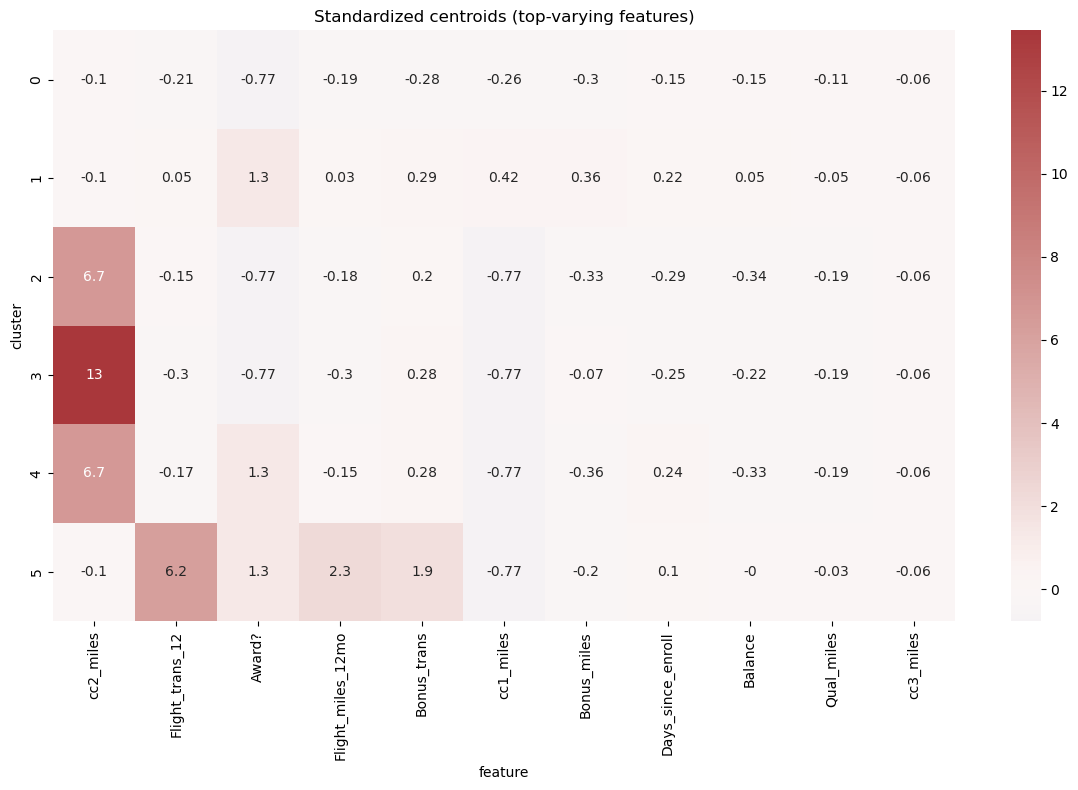

In [14]:
# Cluster counts and centroids
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure labels exist (from Step B) and basic checks
try:
    labels
except NameError:
    raise RuntimeError("Labels not found. Please run Step B cells first.")

# Cluster sizes (including noise)
vc = pd.Series(labels).value_counts().sort_index()
num_noise = int(vc.get(-1, 0))
num_clusters = int(vc[vc.index >= 0].shape[0])
print("Label counts (including noise -1):\n", vc)
print(f"Clusters found (excluding noise): {num_clusters}")
print(f"Noise points: {num_noise} ({num_noise/len(labels):.1%})")

# Centroids in original units (means per cluster)
X_with_labels = X.copy()
X_with_labels['cluster'] = labels
cluster_means_original = X_with_labels[X_with_labels['cluster'] >= 0].groupby('cluster').mean()

# Standardized centroids (means in z-score space)
X_scaled_labeled = X_scaled_df.copy()
X_scaled_labeled['cluster'] = labels
cluster_means_scaled = X_scaled_labeled[X_scaled_labeled['cluster'] >= 0].groupby('cluster').mean()

print("\nCentroids in original units (first 10 features):")
display(cluster_means_original.iloc[:, :10].round(3))

print("\nCentroids (standardized, first 10 features):")
display(cluster_means_scaled.iloc[:, :10].round(3))

# Heatmap for standardized centroids on top-varying features
# Pick features with highest variance across cluster centroids
variances = cluster_means_scaled.var(axis=0)
# Avoid including non-feature column if any
variances = variances.reindex(X_scaled_df.columns)

topk = 12
top_features = variances.sort_values(ascending=False).head(topk).index.tolist()
plt.figure(figsize=(min(12, 1.0*topk), 0.5*topk + 2))
sns.heatmap(cluster_means_scaled[top_features].round(2), annot=True, cmap='vlag', center=0)
plt.title('Standardized centroids (top-varying features)')
plt.ylabel('cluster')
plt.xlabel('feature')
plt.tight_layout()
plt.show()

In [15]:
# Noise point characterization and silhouette score
from sklearn.metrics import silhouette_score

# Identify noise points
noise_mask = labels == -1
non_noise_mask = labels != -1

noise_df = X_scaled_df[noise_mask]
non_noise_df = X_scaled_df[non_noise_mask]

# Z-score extremes: For each feature compute proportion of noise points beyond |z|>2 relative to all points
z_abs = np.abs(X_scaled_df)
extreme_mask = z_abs > 2
extreme_noise_counts = (extreme_mask & noise_mask.reshape(-1,1)).sum(axis=0)
noise_total = noise_mask.sum()
all_extreme_counts = extreme_mask.sum(axis=0)
all_total = X_scaled_df.shape[0]

extreme_ratio_noise = extreme_noise_counts / max(noise_total,1)
extreme_ratio_all = all_extreme_counts / all_total
noise_outlier_enrichment = (extreme_ratio_noise / np.maximum(extreme_ratio_all, 1e-6))

noise_enrichment_df = pd.DataFrame({
    'feature': X_scaled_df.columns,
    'pct_noise_extreme(|z|>2)': (extreme_ratio_noise*100).round(2),
    'pct_all_extreme(|z|>2)': (extreme_ratio_all*100).round(2),
    'enrichment': noise_outlier_enrichment.round(2)
}).sort_values('enrichment', ascending=False)

print("Top 10 features where noise points are enriched for extreme values:")
display(noise_enrichment_df.head(10))

# Silhouette score (exclude noise)
if non_noise_mask.sum() > num_clusters:  # need enough samples
    sil = silhouette_score(X_scaled_df[non_noise_mask], labels[non_noise_mask])
    print(f"Silhouette score (non-noise points): {sil:.3f}")
else:
    print("Not enough non-noise points to compute silhouette score.")

# Basic narrative summary placeholder (can be expanded after inspection)
print("\nInterpretation guidance:")
print("Noise points show enrichment in features with high absolute z-scores; these dimensions likely drive outlier behavior.")

Top 10 features where noise points are enriched for extreme values:


,feature,pct_noise_extreme(|z|>2),pct_all_extreme(|z|>2),enrichment
cc3_miles,cc3_miles,10.29,0.45,22.85
Flight_miles_12mo,Flight_miles_12mo,40.57,3.48,11.67
Flight_trans_12,Flight_trans_12,47.43,4.35,10.90
Qual_miles,Qual_miles,32.00,3.20,10.00
Balance,Balance,30.29,3.58,8.47
Bonus_trans,Bonus_trans,36.00,4.28,8.42
Bonus_miles,Bonus_miles,34.29,4.55,7.53
cc2_miles,cc2_miles,6.29,1.08,5.85
cc1_miles,cc1_miles,28.57,7.20,3.97
Days_since_enroll,Days_since_enroll,2.86,1.80,1.59


Silhouette score (non-noise points): 0.280

Interpretation guidance:
Noise points show enrichment in features with high absolute z-scores; these dimensions likely drive outlier behavior.


## Step D: Cluster Insights & Marketing Recommendations
We'll extract the top distinguishing standardized features per cluster to guide business interpretations, then provide a targeted offer for each cluster.

In [16]:
# Distinguishing features per cluster
# We'll compute per-cluster mean (standardized) and subtract overall mean to see deviations.
overall_mean = X_scaled_df.mean(axis=0)
cluster_deviation = cluster_means_scaled.subtract(overall_mean, axis=1)

# For each cluster list top positive and negative deviations
insights = {}
for cid, row in cluster_deviation.iterrows():
    pos = row.sort_values(ascending=False).head(5)
    neg = row.sort_values(ascending=True).head(5)
    insights[cid] = {
        'top_positive': pos.round(2).to_dict(),
        'top_negative': neg.round(2).to_dict()
    }

import json
print(json.dumps(insights, indent=2))

{
  "0": {
    "top_positive": {
      "cc3_miles": -0.06,
      "cc2_miles": -0.1,
      "Qual_miles": -0.11,
      "Days_since_enroll": -0.15,
      "Balance": -0.15
    },
    "top_negative": {
      "Award?": -0.77,
      "Bonus_miles": -0.3,
      "Bonus_trans": -0.28,
      "cc1_miles": -0.26,
      "Flight_trans_12": -0.21
    }
  },
  "1": {
    "top_positive": {
      "Award?": 1.3,
      "cc1_miles": 0.42,
      "Bonus_miles": 0.36,
      "Bonus_trans": 0.29,
      "Days_since_enroll": 0.22
    },
    "top_negative": {
      "cc2_miles": -0.1,
      "cc3_miles": -0.06,
      "Qual_miles": -0.05,
      "Flight_miles_12mo": 0.03,
      "Balance": 0.05
    }
  },
  "2": {
    "top_positive": {
      "cc2_miles": 6.68,
      "Bonus_trans": 0.2,
      "cc3_miles": -0.06,
      "Flight_trans_12": -0.15,
      "Flight_miles_12mo": -0.18
    },
    "top_negative": {
      "cc1_miles": -0.77,
      "Award?": -0.77,
      "Balance": -0.34,
      "Bonus_miles": -0.33,
      "Days_since_

In [17]:
# Marketing strategy narrative per cluster
from IPython.display import Markdown, display

narrative = []
# Cluster interpretations (manual based on deviations)
# Note: cc2_miles appears extremely high for clusters 2,3,4; cluster 3 is most extreme
narrative.append("### Cluster 0 – Low Engagement / Dormant\nCharacteristics: Generally below-average across flight activity, awards, bonus accumulation, and balance.\nStrategy: Re-activation campaign: targeted email with limited-time double miles on first new flight + easy path to earn an award. Offer small status challenge.")

narrative.append("### Cluster 1 – Loyalty Award Users with Moderate Bonus Activity\nCharacteristics: High Award redemption indicator, moderately higher bonus miles & transactions, slightly higher account age.\nStrategy: Upsell cross-partner earning: promote co-branded credit card bonuses and partner hotel/car earn multipliers to deepen engagement and grow balance.")

narrative.append("### Cluster 2 – Specialized Partner (cc2) Mileage Accumulators (Light Flyers)\nCharacteristics: Extremely high cc2_miles, low flights & award usage, low balance – suggests channel-concentrated earning without redemption.\nStrategy: Encourage redemption & diversify earning: personalized recommendations for near-term award trips; highlight expiration risk & create a bundle offer combining a flight + partner redemption.")

narrative.append("### Cluster 3 – Extreme Partner Mileage Concentrators\nCharacteristics: Off-the-charts cc2_miles (very high), minimal flying, low awards and low balance relative to earning volume (possible transfer spikes).\nStrategy: High-value conversion push: targeted elite fast-track if they shift a minimum number of actual flight segments; offer tier bonus if they book 2+ flights in next quarter.")

narrative.append("### Cluster 4 – Hybrid Partner + Award Engaged\nCharacteristics: High cc2_miles plus high Award? flag; some bonus transactions; modestly higher tenure.\nStrategy: Retention & upsell: introduce milestone bonuses for mixed activity (flights + partner + redemption) to keep them balanced; offer personalized bundle (flight + lounge pass).")

narrative.append("### Cluster 5 – High-Activity Recent Flyers with Bonus Engagement\nCharacteristics: Very high recent flight transactions & miles, elevated bonus transactions, award usage positive; indicates active frequent traveler segment.\nStrategy: Premium upsell: promote elite tier benefits, ancillary revenue offers (priority boarding, seat upgrades), and dynamic upgrade coupons to lock in loyalty.")

narrative.append("### Noise Points – Outliers\nCharacteristics: Feature extremes (|z|>2) on a small subset of dimensions; may represent anomalous or transitional behavior (e.g., sudden large transfer).\nStrategy: Manual review / anomaly handling: flag for fraud/risk scoring if patterns unusual; if legitimate, personalized concierge outreach to convert into sustained engagement.")

full_md = "\n\n".join(narrative)
display(Markdown(full_md))

### Cluster 0 – Low Engagement / Dormant
Characteristics: Generally below-average across flight activity, awards, bonus accumulation, and balance.
Strategy: Re-activation campaign: targeted email with limited-time double miles on first new flight + easy path to earn an award. Offer small status challenge.

### Cluster 1 – Loyalty Award Users with Moderate Bonus Activity
Characteristics: High Award redemption indicator, moderately higher bonus miles & transactions, slightly higher account age.
Strategy: Upsell cross-partner earning: promote co-branded credit card bonuses and partner hotel/car earn multipliers to deepen engagement and grow balance.

### Cluster 2 – Specialized Partner (cc2) Mileage Accumulators (Light Flyers)
Characteristics: Extremely high cc2_miles, low flights & award usage, low balance – suggests channel-concentrated earning without redemption.
Strategy: Encourage redemption & diversify earning: personalized recommendations for near-term award trips; highlight expiration risk & create a bundle offer combining a flight + partner redemption.

### Cluster 3 – Extreme Partner Mileage Concentrators
Characteristics: Off-the-charts cc2_miles (very high), minimal flying, low awards and low balance relative to earning volume (possible transfer spikes).
Strategy: High-value conversion push: targeted elite fast-track if they shift a minimum number of actual flight segments; offer tier bonus if they book 2+ flights in next quarter.

### Cluster 4 – Hybrid Partner + Award Engaged
Characteristics: High cc2_miles plus high Award? flag; some bonus transactions; modestly higher tenure.
Strategy: Retention & upsell: introduce milestone bonuses for mixed activity (flights + partner + redemption) to keep them balanced; offer personalized bundle (flight + lounge pass).

### Cluster 5 – High-Activity Recent Flyers with Bonus Engagement
Characteristics: Very high recent flight transactions & miles, elevated bonus transactions, award usage positive; indicates active frequent traveler segment.
Strategy: Premium upsell: promote elite tier benefits, ancillary revenue offers (priority boarding, seat upgrades), and dynamic upgrade coupons to lock in loyalty.

### Noise Points – Outliers
Characteristics: Feature extremes (|z|>2) on a small subset of dimensions; may represent anomalous or transitional behavior (e.g., sudden large transfer).
Strategy: Manual review / anomaly handling: flag for fraud/risk scoring if patterns unusual; if legitimate, personalized concierge outreach to convert into sustained engagement.

### Which Group to Target for Special Offers?

**Primary Target: Cluster 5 – High-Activity Recent Flyers**

**Why?**
- **Highest engagement:** Very high recent flight transactions (6.18 std) and flight miles (2.34 std) – actively flying and generating revenue
- **Strong loyalty program activity:** Elevated bonus transactions (1.92 std) and award redemption
- **Retention critical:** High-value customers attractive to competitors; retaining them prevents costly churn
- **Best ROI:** Already high spenders; upsell-ready for premium services (upgrades, lounge access, elite status)

**Secondary Target: Cluster 1** – Loyal award users with growth potential through credit card and partner promotions